In [3]:
import hvplot.xarray
import numpy as np
import xarray as xr

In [4]:
def load_merged_argo_dataset_and_tumo(time_smoothing, lat_bounds = None):
    ds_argo_merged = xr.open_dataset(f'../rapid-geostrophic-reconstruction/data/ds_argo_{time_smoothing}.nc')
    t_umo_obs = xr.open_dataset(f'../rapid-geostrophic-reconstruction/data/t_umo_obs.nc')

    t_umo_obs = t_umo_obs.resample(time = time_smoothing).mean()

    ds_argo_merged = ds_argo_merged.sel(time = t_umo_obs.time.data, method = 'nearest')
    ds_argo_merged = ds_argo_merged.isel(z = slice(None, None, -1))

    if lat_bounds is not None:
        ds_argo_merged = ds_argo_merged.where((ds_argo_merged.lat >= lat_bounds[0]) & (ds_argo_merged.lat <= lat_bounds[1]))

    return ds_argo_merged, t_umo_obs

In [5]:
# Load the argo_dataset and the ground truth dataset

import xarray as xr
time_smoothing = '10D'

lat_bounds = (25, 27)


ds_argo_merged, t_umo_obs = load_merged_argo_dataset_and_tumo(time_smoothing)#, lat_bounds = lat_bounds)

In [4]:
import numpy as np
lon_min , lon_max = ds_argo_merged.lon.min(),ds_argo_merged.lon.max() 
lat_min , lat_max = ds_argo_merged.lat.min(),ds_argo_merged.lat.max() 


lon_bin = np.arange(lon_min, lon_max, 6) 
lat_bin = np.arange(lat_min, lat_max, 6) 



In [5]:
lon_min, lon_max, lat_min, lat_max

(<xarray.DataArray 'lon' ()>
 array(-82.87867737),
 <xarray.DataArray 'lon' ()>
 array(-10.6491003),
 <xarray.DataArray 'lat' ()>
 array(23.66731071),
 <xarray.DataArray 'lat' ()>
 array(31.62044907))

In [4]:
lon_bin = np.linspace(-88, -10, 30)
lon_bin, np.diff(lon_bin)

(array([-88.        , -85.31034483, -82.62068966, -79.93103448,
        -77.24137931, -74.55172414, -71.86206897, -69.17241379,
        -66.48275862, -63.79310345, -61.10344828, -58.4137931 ,
        -55.72413793, -53.03448276, -50.34482759, -47.65517241,
        -44.96551724, -42.27586207, -39.5862069 , -36.89655172,
        -34.20689655, -31.51724138, -28.82758621, -26.13793103,
        -23.44827586, -20.75862069, -18.06896552, -15.37931034,
        -12.68965517, -10.        ]),
 array([2.68965517, 2.68965517, 2.68965517, 2.68965517, 2.68965517,
        2.68965517, 2.68965517, 2.68965517, 2.68965517, 2.68965517,
        2.68965517, 2.68965517, 2.68965517, 2.68965517, 2.68965517,
        2.68965517, 2.68965517, 2.68965517, 2.68965517, 2.68965517,
        2.68965517, 2.68965517, 2.68965517, 2.68965517, 2.68965517,
        2.68965517, 2.68965517, 2.68965517, 2.68965517]))

In [5]:
lat_bin = [20,26,32]
lat_bin = np.linspace(20, 32, 50)
lon_bin = np.linspace(-88, -10, 30)
# lon_bin = [-88, -82, -76, -70, -64, -58, -52, -46, -40, -34, -28, -22, -16, -10]

lon_cent = lon_bin[:-1] + np.diff(lon_bin)/2
lat_cent = lat_bin[:-1] + np.diff(lat_bin)/2

In [279]:
%%time
def group_lat(x):
    # x is a DataFrame of group values
    # now find the value of the longitude box to append to the dictionary key
    value = np.ones(1)
    value[0] = x.lon.mean()
    idx = (np.abs(lon_cent - value)).argmin()
    lokey = lon_cent[idx] # longitude value of the box

    # compute groups for the latitude
    y = x.groupby_bins('lat', lat_bin, labels=lat_cent)
    y = dict(y)
    # replace the old key with the new key: lon,lat
    key = np.asarray((list(y.keys()))) # get dict keys as array
    newkey = np.stack((np.ones(len(key))*lokey,key),axis=1)
    newkey = tuple(newkey.tolist())
    key = tuple(y.keys()) # get dict keys as list

    for i in range(len(key)):
        y[tuple(newkey[i])] = y[key[i]]
        del y[key[i]]  
    return y


CPU times: user 11 µs, sys: 1e+03 ns, total: 12 µs
Wall time: 18.1 µs


In [280]:
def bin_argo_time_slice(ds_argo_ti):

    #geop_mean = geop1.groupby_bins('lon', lon_bin, labels=lon_cent).apply(group_lat)
    geop_mean = ds_argo_ti.groupby_bins('lon', lon_bin, labels=lon_cent)
    geop_mean = dict(geop_mean)


    l = 0
    geo_grid = dict()

    for x in list(geop_mean.keys()):
        y = group_lat(geop_mean[x])
        if l == 0:
            geo_grid = y
        else:
            geo_grid.update(y)
        l += 1
    
    l = 0
    m = np.zeros((len(tuple(geo_grid.keys())),4))
    d = np.asarray(list(geo_grid.keys()))

    gp = xr.Dataset(
        {
            'rho': (['lat','lon', 'z'],np.full((lat_cent.shape[0],lon_cent.shape[0], ds_argo_ti.z.shape[0]), np.nan)),
        },
        coords={
            'lon': (['lon'],lon_cent),
            'lat': (['lat'],lat_cent),
            'z': ds_argo_ti.z
        }
    )

    for k in range(d.shape[0]):
        e = tuple(d[k])
        #m[l,2] = geo_grid[e].z.mean()

        if geo_grid[e].pos.shape[0] < 1:
            continue

        try:
            gp['rho'].loc[dict(lat=d[k][1], lon=d[k][0])] = geo_grid[e].rho.mean('pos')
        except:
            print(geo_grid[e].rho.mean('pos'))
            raise ValueError('Error')
        # gp['z'].loc[dict(lat=d[k][1], lon=d[k][0])] = geo_grid[e].z
        #gp.loc[dict(lat=m[0,1], lon=m[0,0])]
        l +=1

    return gp

In [281]:
# for i in range(0,ds_argo_merged.time.shape[0]):
#     binned_ti = bin_argo_time_slice(ds_argo_merged.isel(time = i))
    
# binned_ti.ass


interpolated_merged_argo = xr.concat([bin_argo_time_slice(ds_argo_merged.isel(time = i)) for i in range(ds_argo_merged.time.shape[0])], dim = 'time').assign_coords(time = ds_argo_merged.time)


In [282]:
# standardize the rho values at the bins
from copy import deepcopy


rho_mean = interpolated_merged_argo.rho.mean(['time', 'lon', 'lat'])
rho_std = interpolated_merged_argo.rho.std(['time', 'lon', 'lat', 'z'])

def standardize_rho(ds_pos, rho_mean=None, rho_std=None):
    ds_pos = deepcopy(ds_pos)
    ds_pos["rho"] = (ds_pos["rho"] - rho_mean) / rho_std
    return ds_pos

interpolated_merged_argo_std = standardize_rho(
    interpolated_merged_argo,
    rho_mean=rho_mean, 
    rho_std=rho_std,
)

In [283]:
import hvplot.xarray


interpolated_merged_argo_std.isel(lat = 1, time = 50).rho.hvplot(x = 'lon', y = 'z')

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


:Image   [lon,z]   (rho)

In [284]:
blocks_permuted_indices = np.concatenate([np.arange(starti, min(starti+12, interpolated_merged_argo.time.shape[0])) for starti in np.random.permutation(np.arange(0, interpolated_merged_argo.time.shape[0], 12))])

train_indices = blocks_permuted_indices[:int(.75 * blocks_permuted_indices.shape[0])]
test_indices = blocks_permuted_indices[int(.75 * blocks_permuted_indices.shape[0]):]

X_dataset = interpolated_merged_argo.rho.stack(feature = ('lat', 'lon', 'z')).fillna(0).values


train_X = X_dataset[train_indices]
test_X = X_dataset[test_indices]


train_y = t_umo_obs.dv_dz_times_X.values[train_indices]
test_y = t_umo_obs.dv_dz_times_X.values[test_indices]

In [285]:
from sklearn.linear_model import Lasso, Ridge



ridge = Lasso(alpha=5).fit(train_X, train_y)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.329e-01, tolerance: 2.635e-01
  model = cd_fast.enet_coordinate_descent(


In [293]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10), max_iter=1000, alpha=5,
                    solver='adam', verbose=10,  random_state=21,tol=0.000000001, learning_rate_init=1e-4, learning_rate='adaptive', validation_fraction=.1)

mlp.fit(train_X, train_y)

Iteration 1, loss = 172.11910602
Iteration 2, loss = 273.03244384
Iteration 3, loss = 55.54690028
Iteration 4, loss = 81.64439699
Iteration 5, loss = 65.78117902
Iteration 6, loss = 37.90241612
Iteration 7, loss = 27.94707913
Iteration 8, loss = 29.94755775
Iteration 9, loss = 32.72234550
Iteration 10, loss = 31.38964151
Iteration 11, loss = 25.83137368
Iteration 12, loss = 19.53154576
Iteration 13, loss = 17.08384722
Iteration 14, loss = 16.94231016
Iteration 15, loss = 15.94262322
Iteration 16, loss = 14.38026522
Iteration 17, loss = 12.34320599
Iteration 18, loss = 9.86092165
Iteration 19, loss = 8.68550761
Iteration 20, loss = 8.63411829
Iteration 21, loss = 8.72574199
Iteration 22, loss = 7.87601171
Iteration 23, loss = 7.22240428
Iteration 24, loss = 6.64603663
Iteration 25, loss = 6.09328937
Iteration 26, loss = 5.78839404
Iteration 27, loss = 5.45721498
Iteration 28, loss = 4.96978982
Iteration 29, loss = 4.35849088
Iteration 30, loss = 3.80417218
Iteration 31, loss = 3.5789481

MLPRegressor(alpha=5, hidden_layer_sizes=(10, 10, 10, 10),
             learning_rate='adaptive', learning_rate_init=0.0001, max_iter=1000,
             random_state=21, tol=1e-09, verbose=10)

In [294]:
ridge.score(test_X, test_y)
# mlp.score(test_X, test_y)

-0.4769030208555176

In [324]:
import pandas as pd

estimator = ridge

train_prediction = estimator.predict(train_X)
test_prediction = estimator.predict(test_X)

result_dataframe_train = pd.DataFrame({
    'time': t_umo_obs.time.data[train_indices],
    'true': train_y,
    'prediction': train_prediction,
})

result_dataframe_test = pd.DataFrame({
    'time': t_umo_obs.time.data[test_indices],
    'true': test_y,
    'prediction': test_prediction,
    'difference': test_y - test_prediction,
})

In [325]:
result_dataframe_test.hvplot.line(x='time', y=['true', 'prediction'])

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [322]:
import hvplot.pandas
(
    result_dataframe_train.hvplot.line(x='time', y=['true', 'prediction'])
    + result_dataframe_test.hvplot.line(x='time', y=['true', 'prediction'])
    # + result_dataframe_test.hvplot.line(x='time', y='difference')
).cols(1)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

:Layout
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [time]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [time]   (value)

array([ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,   0,   1,   2,   3,   4,   5,   6,   7,   8,
         9,  10,  11,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       216, 217, 218,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  12,  13,  14,  15,  16,  17,  18,  19,  20,  2

## Merge Argos with naive fix sized bins

In [13]:
lon_bin = np.linspace(-88, -10, 30)

lon_bined_argos = xr.concat([ds_argo_merged.isel(time = i).groupby_bins(group = 'lon', bins = lon_bin).mean() for i in range(ds_argo_merged.time.shape[0])], dim = 'time').assign_coords(time = ds_argo_merged.time)
lon_bined_argos = lon_bined_argos.rename(lon_bins = 'pos')

lon_bined_argos

<xarray.Dataset>
Dimensions:       (z: 242, pos: 29, time: 653)
Coordinates:
  * z             (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * pos           (pos) object (-88.0, -85.31] ... (-12.69, -10.0]
  * time          (time) datetime64[ns] 2004-04-02 2004-04-12 ... 2022-02-07
    pressure      (z) float64 4.82e+03 4.8e+03 4.78e+03 ... 40.0 20.0 0.0
Data variables:
    temperature   (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    salinity      (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    profile_mask  (time, pos) float64 nan nan nan nan nan ... nan nan 1.0 nan
    ct            (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    rho           (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan

## Calculate transport between the argo bins

In [8]:
dv_dz_obs = xr.open_dataset('../rapid-geostrophic-reconstruction/data/dv_dz_obs.nc')
dv_dz_obs = dv_dz_obs.resample(time = time_smoothing).mean()
dv_dz_obs

<xarray.Dataset>
Dimensions:        (z: 242, time: 218)
Coordinates:
  * z              (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * time           (time) datetime64[ns] 2004-04-02 2004-05-02 ... 2022-01-28
Data variables:
    dv_dz_times_X  (time, z) float64 -1.738 -1.677 -1.615 -1.555 ... nan nan nan

In [319]:

def calc_umo_tranport(ds_pos, obs_dv_dz = None):

    g = 9.81
    f = 2 * 7.292116E-5 * np.sin(np.deg2rad(26.5))
    rho0 = 1025.0
    zref = -4800

    rho_diff = xr.concat(
            [
                (
                    ds_pos.isel(pos=start_i + 1).squeeze(drop=True).rho
                    - ds_pos.isel(pos=start_i).squeeze(drop=True).rho
                ).assign_coords(box=f"{start_i}_{start_i+1}")
                for start_i in range(ds_pos.pos.shape[0] - 1)
            ],
            dim="box"
        )

    dv_dz = (- rho_diff * g / f / rho0).sum("box").where(
                (~(- rho_diff * g / f / rho0).isnull()).sum("box") > 0
            ).rename("dv_dz_times_X")

    if obs_dv_dz is not None:

        dv_dz = xr.where(
            dv_dz.where(dv_dz.z > -1000).isnull(),
            dv_dz_obs.sel(time = ds_argo_merged.time[i], method= 'nearest').dv_dz_times_X,
            dv_dz
        )

    # # cut the surface 
    dv_dz = dv_dz.where(dv_dz.z < -150)

    _dv_dz = dv_dz.isel(z=slice(-40, None))
    dv_dz_fillup = xr.where(
        ~dv_dz.isnull(),
        dv_dz,
        (_dv_dz.isel(z=0) + _dv_dz.diff("z").ffill("z").cumsum("z")).interp(z=dv_dz.z)
    )
    
    dv_dz = dv_dz_fillup
    
    transp_umo = (-(
            ((dv_dz.isel(z=slice(None, None, -1)).cumsum("z") * 20.0))
            - ((dv_dz.isel(z=slice(None, None, -1)).cumsum("z") * 20.0)).sel(z=zref, method="nearest")
        ).cumsum("z") * 20.0 / 1e6).sel(z=-1000, method="nearest")

    return transp_umo, dv_dz

In [320]:
transports = []
dv_dz_ts = []
for i in range(ds_argo_merged.time.shape[0]):

    grouped_lons = ds_argo_merged.isel(time = i).groupby_bins(group = 'lon', bins = lon_bin)

    lon_mask_deeper_than1000dbar = grouped_lons.count().rho.sum('z') > (~ds_argo_merged.z.where(ds_argo_merged.z > -1000).isnull()).sum()
    lon_mask_deeper_than1000dbar = lon_mask_deeper_than1000dbar.rename(lon_bins = 'pos')

    ds_pos = grouped_lons.mean().rename(lon_bins = 'pos').where(lon_mask_deeper_than1000dbar, drop = True)
    transport, dv_dz_t = calc_umo_tranport(ds_pos, dv_dz_obs.sel(time = ds_argo_merged.time[i], method= 'nearest'))
    transports.append(transport)
    dv_dz_ts.append(dv_dz_t)


transport = xr.concat(transports, dim = 'time').assign_coords(time = ds_argo_merged.time.isel(time = slice(None, None)))
ds_dv_dz = xr.concat(dv_dz_ts, dim = 'time').assign_coords(time = ds_argo_merged.time.isel(time = slice(None, None)))

In [313]:
i = 40
grouped_lons = ds_argo_merged.isel(time = i).groupby_bins(group = 'lon', bins = lon_bin)

lon_mask_deeper_than1000dbar = grouped_lons.count().rho.sum('z') > (~ds_argo_merged.z.where(ds_argo_merged.z > -1000).isnull()).sum()
lon_mask_deeper_than1000dbar = lon_mask_deeper_than1000dbar.rename(lon_bins = 'pos')

ds_pos = grouped_lons.mean().rename(lon_bins = 'pos').where(lon_mask_deeper_than1000dbar, drop = True)
transport_t, dv_dz_t = calc_umo_tranport(ds_pos,dv_dz_obs.sel(time = ds_argo_merged.time[i], method= 'nearest'))


In [314]:
ds_dv_dz

<xarray.DataArray 'dv_dz_times_X' (time: 218, z: 242)>
array([[  -1.73788028,   -1.67721806,   -1.61499101, ...,  -65.22384453,
         -66.91986742,  -70.9779539 ],
       [  -1.4513314 ,   -1.88806718,   -1.86243499, ..., -161.55987152,
        -158.06077956, -154.42281093],
       [  -1.16991775,   -1.9424    ,   -1.9482271 , ..., -103.8669038 ,
        -109.38984839, -127.83897486],
       ...,
       [          nan,           nan,           nan, ..., -266.43122507,
        -265.89856895, -266.05936984],
       [          nan,           nan,           nan, ..., -317.54597337,
        -327.48660416, -329.62705573],
       [          nan,           nan,           nan, ..., -312.35659002,
        -319.47363734, -615.83438486]])
Coordinates:
  * z         (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * time      (time) datetime64[ns] 2004-04-02 2004-05-02 ... 2022-01-28
    pressure  (z) float64 4.82e+03 4.8e+03 4.78e+03 4.76e+03 ... 40.0 20.0 0.0

In [321]:
dv_dz_obs_t = dv_dz_obs
_dv_dz = dv_dz_obs_t.isel(z=slice(-40, None)).dv_dz_times_X
dv_dz_fillup = xr.where(
    ~dv_dz_obs_t.isnull(),
    dv_dz_obs_t,
    (_dv_dz.isel(z=0) + _dv_dz.diff("z").ffill("z").cumsum("z")).interp(z=dv_dz_obs_t.z)
)

(
    ds_dv_dz.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'argo')
    * dv_dz_fillup.mean('time').hvplot(label = 'obs')
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.Argo :Curve   [z]   (dv_dz_times_X)
   .Curve.Obs  :Curve   [z]   (dv_dz_times_X)

In [311]:
dv_dz_obs_t = dv_dz_obs.isel(time = i)
_dv_dz = dv_dz_obs_t.isel(z=slice(-40, None)).dv_dz_times_X
dv_dz_fillup = xr.where(
    ~dv_dz_obs_t.isnull(),
    dv_dz_obs_t,
    (_dv_dz.isel(z=0) + _dv_dz.diff("z").ffill("z").cumsum("z")).interp(z=dv_dz_obs_t.z)
)
print('Obs',t_umo_obs.isel(time = i).dv_dz_times_X.data[()],'argo', transport_t.data[()])
(
    dv_dz_t.hvplot(x = 'z', y = 'dv_dz_times_X', label = 'argo')
    * dv_dz_fillup.hvplot(label = 'obs')
)


Obs -16.68308914944781 argo -22.47092474568682


/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.Argo :Curve   [z]   (dv_dz_times_X)
   .Curve.Obs  :Curve   [z]   (dv_dz_times_X)

In [305]:
import hvplot.xarray
(
    transport.hvplot(label = 'Argo')
    *
    t_umo_obs.dv_dz_times_X.hvplot(label = 'Rapid')
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.Argo  :Curve   [time]   (dv_dz_times_X)
   .Curve.Rapid :Curve   [time]   (dv_dz_times_X)

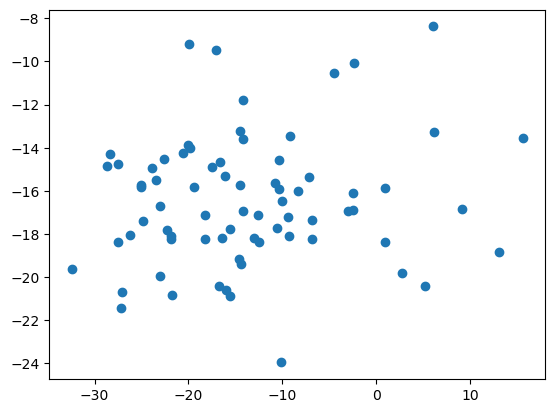

In [260]:
import matplotlib.pyplot as plt
plt.scatter(transport.values, t_umo_obs.dv_dz_times_X.values)

In [261]:
from sklearn.metrics import r2_score

r2_score(t_umo_obs.dv_dz_times_X.values, transport.values)

-12.217427679502592

## Merging to the boundaries 

In [6]:
ds_argo_merged_10days, _ = load_merged_argo_dataset_and_tumo('10D', lat_bounds = lat_bounds)

def calc_merged_profiles_from_ds_argo_per_t(ds_argo_ti, compartments):
    ds_argo_ti = ds_argo_ti.sortby('lon')
    ds_argo_ti = ds_argo_ti.assign_coords(pos_i = ('pos', np.arange(ds_argo_ti.lon.shape[0])))

    compartment_profiles = []
    for compartment in compartments:
        argo_pos_mask = (ds_argo_ti.lon >= compartment[1]) & (ds_argo_ti.lon <= compartment[2]) & (ds_argo_ti.profile_mask == 1)

        if argo_pos_mask.sum() == 0:
            return None

        ds_argo_ti_comp = ds_argo_ti.where(argo_pos_mask, drop = True)
        valid_values_mask =(~ds_argo_ti_comp.temperature.isnull())

        if compartment[3] == 'west':
            westward_indices = ds_argo_ti_comp.pos_i.where(valid_values_mask).min('pos')
            westward_indices = westward_indices.fillna(westward_indices.min()).astype(int)
            merged_profile = ds_argo_ti.isel(pos = westward_indices)
        elif compartment[3] == 'east':
            eastward_indices = ds_argo_ti_comp.pos_i.where(valid_values_mask).max('pos')
            eastward_indices = eastward_indices.fillna(eastward_indices.max()).astype(int)
            merged_profile = ds_argo_ti.isel(pos = eastward_indices)
        else:
            raise ValueError('Unknown compartment direction')
        merged_profile = merged_profile.drop_vars('pos')
        compartment_profiles.append(merged_profile)

    compartment_profiles = xr.concat(compartment_profiles, dim = 'pos')
    compartment_profiles = compartment_profiles.assign_coords(pos = [c[0] for c in compartments])

    return compartment_profiles


compartments = [
    ['west_p', -76.74, -70, 'west'],
    ['mar_west_p', -60, -47, 'east'],
    ['mar_east_p', -47, -40, 'west'],
    ['east_p', -30, -13.5, 'east']
]

ds_argo_compartment_list = []
time_is_argo_compartment_list = []
for i in range(ds_argo_merged_10days.time.shape[0]):
    ds_compartment_ti = calc_merged_profiles_from_ds_argo_per_t(ds_argo_merged_10days.isel(time = i), compartments)
    
    if ds_compartment_ti is None:
        continue
    ds_argo_compartment_list.append(ds_compartment_ti)
    time_is_argo_compartment_list.append(i)
    

ds_argo_compartment = xr.concat(ds_argo_compartment_list, dim = 'time').assign_coords(time = ds_argo_merged_10days.time.isel(time = time_is_argo_compartment_list))


ds_argo_compartment = ds_argo_compartment.resample(time = time_smoothing).mean()
ds_argo_compartment = ds_argo_compartment.where(ds_argo_compartment.profile_mask == 1, drop = True)


ds_argo_compartment

<xarray.Dataset>
Dimensions:       (time: 360, pos: 4, z: 242)
Coordinates:
  * z             (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * pos           (pos) <U10 'west_p' 'mar_west_p' 'mar_east_p' 'east_p'
  * time          (time) datetime64[ns] 2006-12-28 2007-01-07 ... 2021-11-29
    pressure      (z) float64 4.82e+03 4.8e+03 4.78e+03 ... 40.0 20.0 0.0
Data variables:
    temperature   (time, pos, z) float64 nan nan nan nan ... 22.73 22.72 22.7
    salinity      (time, pos, z) float64 nan nan nan nan ... 37.33 37.29 37.29
    profile_mask  (time, pos, z) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ct            (time, pos, z) float64 nan nan nan nan ... 22.65 22.64 22.63
    rho           (time, pos, z) float64 nan nan nan ... 1.026e+03 1.026e+03

## Aggregated profiles


Merged to compartments: 

In [7]:
ds_argo_compartment

<xarray.Dataset>
Dimensions:       (time: 360, pos: 4, z: 242)
Coordinates:
  * z             (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * pos           (pos) <U10 'west_p' 'mar_west_p' 'mar_east_p' 'east_p'
  * time          (time) datetime64[ns] 2006-12-28 2007-01-07 ... 2021-11-29
    pressure      (z) float64 4.82e+03 4.8e+03 4.78e+03 ... 40.0 20.0 0.0
Data variables:
    temperature   (time, pos, z) float64 nan nan nan nan ... 22.73 22.72 22.7
    salinity      (time, pos, z) float64 nan nan nan nan ... 37.33 37.29 37.29
    profile_mask  (time, pos, z) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ct            (time, pos, z) float64 nan nan nan nan ... 22.65 22.64 22.63
    rho           (time, pos, z) float64 nan nan nan ... 1.026e+03 1.026e+03

Naive binning:

In [14]:
lon_bined_argos

<xarray.Dataset>
Dimensions:       (z: 242, pos: 29, time: 653)
Coordinates:
  * z             (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * pos           (pos) object (-88.0, -85.31] ... (-12.69, -10.0]
  * time          (time) datetime64[ns] 2004-04-02 2004-04-12 ... 2022-02-07
    pressure      (z) float64 4.82e+03 4.8e+03 4.78e+03 ... 40.0 20.0 0.0
Data variables:
    temperature   (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    salinity      (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    profile_mask  (time, pos) float64 nan nan nan nan nan ... nan nan 1.0 nan
    ct            (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    rho           (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan

## Baseline 1

Use the merged product to append this to the $dvdz$ of the rapid array and calculate the tranport.

In [9]:
# Loading the dv_dz data from the rapid calculation 
dv_dz_obs = xr.open_dataset('../rapid-geostrophic-reconstruction/data/dv_dz_obs.nc')
dv_dz_obs = dv_dz_obs.resample(time = time_smoothing).mean()
dv_dz_obs

<xarray.Dataset>
Dimensions:        (z: 242, time: 653)
Coordinates:
  * z              (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * time           (time) datetime64[ns] 2004-04-02 2004-04-12 ... 2022-02-07
Data variables:
    dv_dz_times_X  (time, z) float64 -1.81 -1.795 -1.728 -1.664 ... nan nan nan

In [10]:

def calc_umo_tranport(ds_pos, obs_dv_dz = None, depth_obs_concat = -1000):

    g = 9.81
    f = 2 * 7.292116E-5 * np.sin(np.deg2rad(26.5))
    rho0 = 1025.0
    zref = -4800

    rho_diff = xr.concat(
            [
                (
                    ds_pos.isel(pos=start_i + 1).squeeze(drop=True).rho
                    - ds_pos.isel(pos=start_i).squeeze(drop=True).rho
                ).assign_coords(box=f"{start_i}_{start_i+1}")
                for start_i in range(ds_pos.pos.shape[0] - 1)
            ],
            dim="box"
        )

    dv_dz = (- rho_diff * g / f / rho0).sum("box").where(
                (~(- rho_diff * g / f / rho0).isnull()).sum("box") > 0
            ).rename("dv_dz_times_X")

    if obs_dv_dz is not None:

        dv_dz = xr.where(
            (~dv_dz.where(dv_dz.z > depth_obs_concat).isnull()),
            dv_dz,
            obs_dv_dz.dv_dz_times_X.data,
        )

    # # cut the surface 
    dv_dz = dv_dz.where(dv_dz.z < -150)

    _dv_dz = dv_dz.isel(z=slice(-40, None))
    dv_dz_fillup = xr.where(
        ~dv_dz.isnull(),
        dv_dz,
        (_dv_dz.isel(z=0) + _dv_dz.diff("z").ffill("z").cumsum("z")).interp(z=dv_dz.z)
    )
    
    dv_dz = dv_dz_fillup
    
    transp_umo = (-(
            ((dv_dz.isel(z=slice(None, None, -1)).cumsum("z") * 20.0))
            - ((dv_dz.isel(z=slice(None, None, -1)).cumsum("z") * 20.0)).sel(z=zref, method="nearest")
        ).cumsum("z") * 20.0 / 1e6).sel(z=-1000, method="nearest")

    return transp_umo, dv_dz

In [11]:
def cacluate_transport_neighboring_filled_pos(ds_pos_rho, min_argo_depth):
    transports = []
    dv_dz_ts = []

    lon_mask_deeper_than = (~ds_pos_rho.rho.isnull()).sum('z') >= (~ds_pos_rho.z.where(ds_pos_rho.z > min_argo_depth).isnull()).sum()
    valid_times_mask = lon_mask_deeper_than.sum('pos') > 1

    ds_pos_rho = ds_pos_rho.where(valid_times_mask, drop = True)

    for i in range(ds_pos_rho.time.shape[0]):

        ds_pos_rho_t = ds_pos_rho.isel(time = i)

        lon_mask_deeper_than1000dbar = (~ds_pos_rho_t.rho.isnull()).sum('z') >= (~ds_pos_rho_t.z.where(ds_pos_rho_t.z > min_argo_depth).isnull()).sum()
        

        ds_pos_rho_t_valid = ds_pos_rho_t.where(lon_mask_deeper_than1000dbar, drop = True)
        try:
            transport, dv_dz_t = calc_umo_tranport(ds_pos_rho_t_valid, dv_dz_obs.sel(time = ds_pos_rho_t.time, method= 'nearest'), depth_obs_concat=min_argo_depth)
            # transport, dv_dz_t = calc_umo_tranport(ds_pos_rho_t_valid, None, depth_obs_concat=min_argo_depth)
        except Exception as e:
            # print the time index and raise the error
            print(i)
            raise e
        
        transports.append(transport)
        dv_dz_ts.append(dv_dz_t)


    transport = xr.concat(transports, dim = 'time').assign_coords(time = ds_pos_rho.time.isel(time = slice(None, None)))
    ds_dv_dz = xr.concat(dv_dz_ts, dim = 'time').assign_coords(time = ds_pos_rho.time.isel(time = slice(None, None)))

    return transport, ds_dv_dz

In [15]:
t_binned_argo_1000, dv_dz_binned_argo_1000 = cacluate_transport_neighboring_filled_pos(lon_bined_argos, -1000)
t_binned_argo_2000, dv_dz_binned_argo_2000 = cacluate_transport_neighboring_filled_pos(lon_bined_argos, -2000)

In [16]:
t_merged_argo_1000, dv_dz_merged_argo_1000 = cacluate_transport_neighboring_filled_pos(ds_argo_compartment, -1000)
t_merged_argo_2000, dv_dz_merged_argo_2000 = cacluate_transport_neighboring_filled_pos(ds_argo_compartment, -2000)

In [17]:
(
    (
        t_binned_argo_1000.hvplot(label = 'argo_1000dbar')
        * t_binned_argo_2000.hvplot(label = 'argo_2000dbar')
        * t_umo_obs.hvplot(label = 'rapid')
    )
    + (
        t_merged_argo_1000.hvplot(label = 'merged_1000dbar', color = 'gray')
        * t_merged_argo_2000.hvplot(label = 'merged_2000dbar', color = 'gray', line_dash = 'dashed')
        * t_umo_obs.hvplot(label = 'rapid')
    )
    # + (
    #     dv_dz_binned_argo_1000.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'argo_1000dbar')
    #     * dv_dz_binned_argo_2000.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'argo_2000dbar')
    #     * dv_dz_obs.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'obs')
    
    # )
    # + (
    #     (t_merged_argo_1000 - t_binned_argo_1000).hvplot(label = 'merged-binned_1000dbar')
    #     * (t_merged_argo_2000 - t_binned_argo_2000).hvplot(label = 'merged-binned_2000dbar')
        
    # )
).cols(1).opts(title = f'For {time_smoothing} as smoothing')


/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

:Layout
   .Overlay.I  :Overlay
      .Curve.Argo_1000dbar :Curve   [time]   (dv_dz_times_X)
      .Curve.Argo_2000dbar :Curve   [time]   (dv_dz_times_X)
      .Curve.Rapid         :Curve   [time]   (dv_dz_times_X)
   .Overlay.II :Overlay
      .Curve.Merged_1000dbar :Curve   [time]   (dv_dz_times_X)
      .Curve.Merged_2000dbar :Curve   [time]   (dv_dz_times_X)
      .Curve.Rapid           :Curve   [time]   (dv_dz_times_X)

In [339]:
(
    (
        dv_dz_binned_argo_1000.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'argo_1000dbar')
        * dv_dz_binned_argo_2000.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'argo_2000dbar')
        * dv_dz_obs.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'obs')
    )
    + (
        dv_dz_merged_argo_1000.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'merged_1000dbar')
        * dv_dz_merged_argo_2000.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'merged_2000dbar')
        * dv_dz_obs.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'obs')
    )
).cols(1)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

:Layout
   .Overlay.I  :Overlay
      .Curve.Argo_1000dbar :Curve   [z]   (dv_dz_times_X)
      .Curve.Argo_2000dbar :Curve   [z]   (dv_dz_times_X)
      .Curve.Obs           :Curve   [z]   (dv_dz_times_X)
   .Overlay.II :Overlay
      .Curve.Merged_1000dbar :Curve   [z]   (dv_dz_times_X)
      .Curve.Merged_2000dbar :Curve   [z]   (dv_dz_times_X)
      .Curve.Obs             :Curve   [z]   (dv_dz_times_X)

In [18]:
t_binned_argo_1000.sel(time = slice("1-1-2010", None))

<xarray.DataArray 'dv_dz_times_X' (time: 443)>
array([-22.31661788, -17.3968004 , -15.7081944 , -14.40467016,
       -23.51977559, -24.79059242, -31.70870136, -31.89143373,
       -30.93089491, -24.3907885 , -22.24154285, -22.99452379,
       -10.39541496, -11.50252224, -13.55893419, -10.02264664,
       -36.8012018 , -14.05687913, -19.60214713, -17.01404857,
        -1.92989135, -20.9923884 , -10.37241053,  -5.66431601,
       -11.01258364, -18.21368309, -19.37695587, -16.9244985 ,
       -15.15920016, -21.57264578, -21.31874485, -19.20752454,
       -28.46368797, -25.9078552 , -29.48708595, -36.22419941,
       -29.85837075, -24.87696933, -21.98876556, -24.00746459,
       -22.23642074, -25.0086588 , -24.48183311, -27.65059958,
       -26.92801838, -30.29517161, -21.60345583, -28.27611479,
       -28.56310326, -27.65734605, -28.72864062, -37.40711506,
       -21.95969527, -20.00079663, -16.51057842, -20.61540159,
       -19.87391861, -20.33051254, -15.83343764, -11.57125516,
       -11.98312169, -19.30666116, -27.54372895, -24.23036268,
       -12.83740594, -10.91668755, -13.24461143,  -0.21655422,
         0.43372926, -23.56522123, -13.76041179, -12.89416976,
       -16.86524247, -24.26901568, -21.09993809, -11.5780506 ,
       -10.6704261 , -10.66831326, -12.79362136, -15.71625541,
...
       -22.6609974 , -22.22613475, -20.35311902, -20.58080163,
       -22.36527677, -16.95130425, -18.93525963, -15.71402027,
       -10.58692429, -12.48760676, -16.7099139 , -15.85395814,
        -6.20058741,  -5.96051083, -15.93387154, -17.46848856,
       -23.61876832, -23.53916049, -26.27604132, -39.75601709,
       -36.36771599, -23.083486  , -19.4522823 , -15.7176342 ,
       -30.50394964, -38.1095732 , -29.58401252, -28.79848407,
       -25.66395749, -12.96135999, -16.22989663, -25.69958611,
        -4.86956908,  -3.33805012, -12.48341826, -20.02100757,
       -13.9713867 , -19.78177109, -17.94760559, -22.12447481,
       -20.33125462, -28.12383102, -19.86548361, -24.40653535,
       -20.25112192, -21.73710379, -11.96545238, -15.0227572 ,
       -15.73845671,  -6.0771525 , -10.97112638, -13.96696855,
       -21.57639867,  -2.47435589,  -7.5442424 ,  -8.51989494,
        -7.19507033,  -6.58635842,  -8.44416789, -15.5649956 ,
       -11.81355484, -19.9636123 , -16.31612592, -16.77067727,
        -8.28395499,  -5.6549194 ,  -4.89556682,  -6.38006882,
       -12.45490996, -11.02133115, -14.04056257, -14.1656278 ,
       -15.03466114, -17.31810395, -19.20767782, -21.23751826,
       -21.31453722, -20.52960547, -17.08345532])
Coordinates:
    z        float64 -1e+03
  * time     (time) datetime64[ns] 2010-01-01 2010-01-11 ... 2022-02-07

In [19]:
# Print the R2 score for the 1000 dbar and 2000 dbar transport to the rapid calculation
# For this make a fancy format in form of a table
from sklearn.metrics import r2_score, mean_absolute_error

print('R2 score for the 1000 dbar transport')
print('-------------------------------------')
print(f'Binned: {r2_score(t_umo_obs.sel(time = t_binned_argo_1000.time, method = "nearest").dv_dz_times_X.values, t_binned_argo_1000.values)}')
print(f'Merged: {r2_score(t_umo_obs.sel(time = t_merged_argo_1000.time, method = "nearest").dv_dz_times_X.values, t_merged_argo_1000.values)}')
print('-------------------------------------')
print('R2 score for the 2000 dbar transport')
print('-------------------------------------')
print(f'Binned: {r2_score(t_umo_obs.sel(time = t_binned_argo_2000.time, method = "nearest").dv_dz_times_X.values, t_binned_argo_2000.values)}')
print(f'Merged: {r2_score(t_umo_obs.sel(time = t_merged_argo_2000.time, method = "nearest").dv_dz_times_X.values, t_merged_argo_2000.values)}')
print('-------------------------------------')
print('MAE score for the 1000 dbar transport')
print('-------------------------------------')
print(f'Binned: {mean_absolute_error(t_umo_obs.sel(time = t_binned_argo_1000.time, method = "nearest").dv_dz_times_X.values, t_binned_argo_1000.values):.2f} Sv')
print(f'Merged: {mean_absolute_error(t_umo_obs.sel(time = t_merged_argo_1000.time, method = "nearest").dv_dz_times_X.values, t_merged_argo_1000.values):.2f} Sv')
print('-------------------------------------')
print('MAE score for the 2000 dbar transport')
print('-------------------------------------')
print(f'Binned: {mean_absolute_error(t_umo_obs.sel(time = t_binned_argo_2000.time, method = "nearest").dv_dz_times_X.values, t_binned_argo_2000.values):.2f} Sv')
print(f'Merged: {mean_absolute_error(t_umo_obs.sel(time = t_merged_argo_2000.time, method = "nearest").dv_dz_times_X.values, t_merged_argo_2000.values):.2f} Sv')

R2 score for the 1000 dbar transport
-------------------------------------
Binned: -2.2823899653295054
Merged: -1.1517757417301064
-------------------------------------
R2 score for the 2000 dbar transport
-------------------------------------
Binned: -4.34789847710499
Merged: -2.597293541638154
-------------------------------------
MAE score for the 1000 dbar transport
-------------------------------------
Binned: 6.72 Sv
Merged: 5.34 Sv
-------------------------------------
MAE score for the 2000 dbar transport
-------------------------------------
Binned: 8.71 Sv
Merged: 6.72 Sv


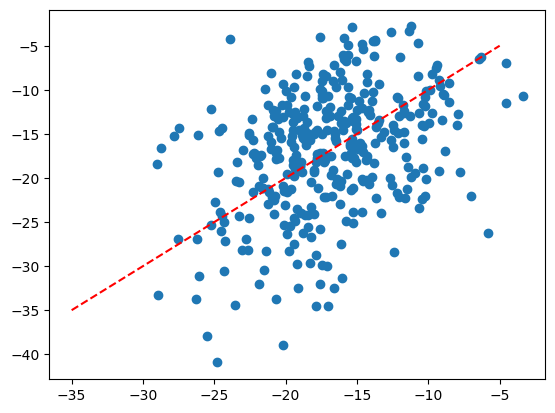

In [20]:
import matplotlib.pyplot as plt
plt.scatter(t_umo_obs.sel(time = t_merged_argo_1000.time, method = "nearest").dv_dz_times_X.values, t_merged_argo_1000.values)

plt.plot([-35, -5], [-35, -5], 'r--')

## Baseline 2

In [70]:
input_X = ds_argo_compartment

In [71]:


# standardize the rho values at the bins
from copy import deepcopy
input_X

<xarray.Dataset>
Dimensions:       (time: 360, pos: 4, z: 242)
Coordinates:
  * z             (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * pos           (pos) <U10 'west_p' 'mar_west_p' 'mar_east_p' 'east_p'
  * time          (time) datetime64[ns] 2006-12-28 2007-01-07 ... 2021-11-29
    pressure      (z) float64 4.82e+03 4.8e+03 4.78e+03 ... 40.0 20.0 0.0
Data variables:
    temperature   (time, pos, z) float64 nan nan nan nan ... 22.73 22.72 22.7
    salinity      (time, pos, z) float64 nan nan nan nan ... 37.33 37.29 37.29
    profile_mask  (time, pos, z) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ct            (time, pos, z) float64 nan nan nan nan ... 22.65 22.64 22.63
    rho           (time, pos, z) float64 nan nan nan ... 1.026e+03 1.026e+03

In [72]:
dv_dz_obs = xr.open_dataset('../rapid-geostrophic-reconstruction/data/dv_dz_obs.nc')
dv_dz_obs = dv_dz_obs.resample(time = time_smoothing).mean()


_dv_dz = dv_dz_obs.isel(z=slice(-40, None)).dv_dz_times_X
dv_dz_obs_fillup = xr.where(
    ~dv_dz_obs.isnull(),
    dv_dz_obs,
    (_dv_dz.isel(z=0) + _dv_dz.diff("z").ffill("z").cumsum("z")).interp(z=dv_dz_obs.z)
)
target_y = dv_dz_obs_fillup.dv_dz_times_X
target_y = target_y.sel(time = input_X.time, method = 'nearest')

valid_ts_mask = target_y.isnull().sum('z') == 0
target_y = target_y.where(valid_ts_mask, drop = True)
input_X = input_X.isel(time = valid_ts_mask.data)


In [73]:
permute = False
train_ratio = .5
if permute: 
    blocks_permuted_indices = np.concatenate([np.arange(starti, min(starti+12, input_X.time.shape[0])) for starti in np.random.permutation(np.arange(0, input_X.time.shape[0], 12))])
else :
    blocks_permuted_indices = np.arange(input_X.time.shape[0])


train_indices = blocks_permuted_indices[:int( train_ratio * blocks_permuted_indices.shape[0])]
test_indices = blocks_permuted_indices[int(train_ratio * blocks_permuted_indices.shape[0]):]

In [74]:

rho_mean = input_X.rho.isel(time = train_indices).mean(['time', 'pos'])
rho_std = input_X.rho.isel(time = train_indices).std(['time', 'pos', 'z'])

def standardize_rho(ds_pos, rho_mean=None, rho_std=None):
    ds_pos = deepcopy(ds_pos)
    ds_pos["rho"] = (ds_pos["rho"] - rho_mean) / rho_std
    return ds_pos

input_X_std = standardize_rho(
    input_X,
    rho_mean=rho_mean, 
    rho_std=rho_std,
)

input_X_std = input_X_std.fillna(0)
input_X_std = input_X_std.rho.stack(feature = ('pos', 'z'))

In [75]:

train_X = input_X_std.values[train_indices]
test_X = input_X_std.values[test_indices]

train_y = target_y.values[train_indices]
test_y = target_y.values[test_indices]

In [76]:
mean_per_z = np.mean(train_y, axis = 0)
std_per_z = np.std(train_y, axis = 0)

train_y_scaled = (train_y - mean_per_z) / std_per_z
test_y_scaled = (test_y - mean_per_z) / std_per_z

In [77]:
from sklearn.linear_model import Lasso, MultiTaskLassoCV, Ridge, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct

In [88]:
# regressor = Lasso(alpha=.1).fit(train_X, train_y)
# regressor = Ridge(alpha=.3).fit(train_X, train_y_scaled)
regressor = RidgeCV(alphas=[.01, .05,.08,.1, .15,.3, .5, 1, 5, 10]).fit(train_X, train_y_scaled)
# regressor = GaussianProcessRegressor(DotProduct() + WhiteKernel()).fit(train_X, train_y)
# regressor = MLPRegressor(hidden_layer_sizes=(1024,1024, 512), max_iter=1000, alpha=.001,
                    # solver='adam', verbose=10,  random_state=21,tol=0.000000001, learning_rate_init=1e-3, learning_rate='adaptive', validation_fraction=.1, early_stopping=True, n_iter_no_change=40).fit(train_X, train_y_scaled)

In [89]:
regressor.score(test_X, test_y_scaled)#, regressor.alpha_

-1.165977288198204

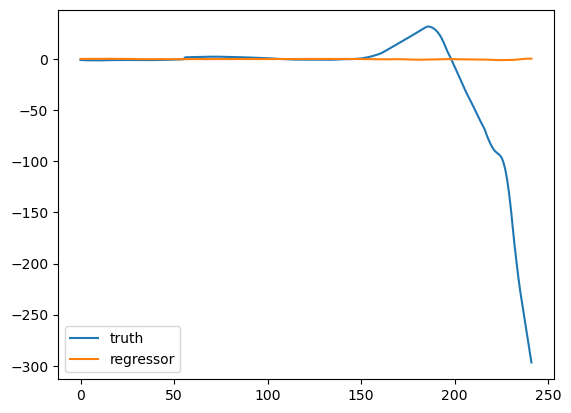

In [91]:
import matplotlib.pyplot as plt
i = 3

plt.plot(test_y[i], label = 'truth')
plt.plot(regressor.predict(test_X)[i], label = 'regressor')
plt.legend()

In [83]:

def prediction_to_tranport(prediction, time_array, z_array ):

    dv_dz_prediction = xr.DataArray(
        prediction,
        dims = ['time', 'z'],
        coords = {
            'time': time_array,
            'z': z_array
        }
    ).rename('dv_dz_times_X')

    transp_umo_prediction = (-(
        ((dv_dz_prediction.isel(z=slice(None, None, -1)).cumsum("z") * 20.0))
        - ((dv_dz_prediction.isel(z=slice(None, None, -1)).cumsum("z") * 20.0)).sel(z=-4800, method="nearest")
    ).cumsum("z") * 20.0 / 1e6).sel(z=-1000, method="nearest")

    return transp_umo_prediction


In [84]:
test_predictions = regressor.predict(test_X)
test_predictions = (test_predictions * std_per_z) + mean_per_z
transp_umo_prediction = prediction_to_tranport(test_predictions, target_y.time.isel(time = test_indices), target_y.z)


In [85]:
(
    transp_umo_prediction.hvplot(label = 'LR')
    * t_umo_obs.sel(time = transp_umo_prediction.time, method = 'nearest').hvplot(label = 'rapid')
    # * t_merged_argo_2000.sel(time = transp_umo_prediction.time, method = 'nearest').hvplot(label = 'merged_2000dbar')
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.LR    :Curve   [time]   (dv_dz_times_X)
   .Curve.Rapid :Curve   [time]   (dv_dz_times_X)

In [86]:
# calc R2 score
from sklearn.metrics import r2_score, mean_absolute_error

In [87]:
print(f'R2: {r2_score(t_umo_obs.sel(time = transp_umo_prediction.time, method = "nearest").dv_dz_times_X.values, transp_umo_prediction.values)}')
print(f'MAE: {mean_absolute_error(t_umo_obs.sel(time = transp_umo_prediction.time, method = "nearest").dv_dz_times_X.values, transp_umo_prediction.values)}')


R2: -0.6014132367097198
MAE: 4.629247323268278


## Baseline 4

In [41]:
from sklearn.decomposition import PCA

In [42]:
dv_dz_obs = xr.open_dataset('../rapid-geostrophic-reconstruction/data/dv_dz_obs.nc')
dv_dz_obs = dv_dz_obs.resample(time = time_smoothing).mean()


_dv_dz = dv_dz_obs.isel(z=slice(-40, None)).dv_dz_times_X
dv_dz_obs_fillup = xr.where(
    ~dv_dz_obs.isnull(),
    dv_dz_obs,
    (_dv_dz.isel(z=0) + _dv_dz.diff("z").ffill("z").cumsum("z")).interp(z=dv_dz_obs.z)
)
target_y = dv_dz_obs_fillup.dv_dz_times_X
target_y = target_y.sel(time = input_X.time, method = 'nearest')

valid_ts_mask = target_y.isnull().sum('z') == 0
target_y = target_y.where(valid_ts_mask, drop = True)

In [43]:
pca = PCA(n_components=15).fit(train_y)

(array([ 9., 14., 43., 60., 62., 73., 49., 12.,  6.,  4.]),
 array([-46.39211534, -36.32379483, -26.25547432, -16.1871538 ,
         -6.11883329,   3.94948722,  14.01780773,  24.08612824,
         34.15444876,  44.22276927,  54.29108978]),
 <BarContainer object of 10 artists>)

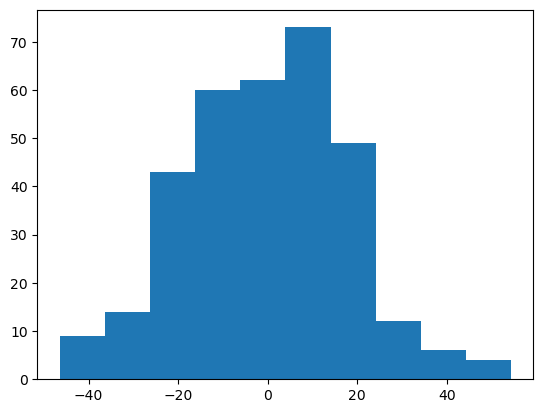

In [44]:
plt.hist(pca.transform(target_y.values)[:, 4])

In [64]:

regressor = Ridge(alpha=01.4).fit(train_X, pca.transform(train_y))


# regressor = MLPRegressor(hidden_layer_sizes=(1024,512, 32), max_iter=1000, alpha=.001,
#                     solver='adam', verbose=10,  random_state=21,tol=0.000000001, learning_rate_init=1e-3, learning_rate='adaptive', validation_fraction=.1, early_stopping=True, n_iter_no_change=40).fit(train_X, pca.transform(train_y))

In [65]:
regressor.score(test_X, pca.transform(test_y))

-0.38743108695739764

In [66]:
test_predictions = regressor.predict(test_X)

test_predictions = pca.inverse_transform(test_predictions)




transp_umo_prediction = prediction_to_tranport(test_predictions, target_y.time.isel(time = test_indices), target_y.z)


In [67]:
(
    transp_umo_prediction.hvplot(label = 'LR')
    * t_umo_obs.sel(time = transp_umo_prediction.time, method = 'nearest').hvplot(label = 'rapid')
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.LR    :Curve   [time]   (dv_dz_times_X)
   .Curve.Rapid :Curve   [time]   (dv_dz_times_X)

In [68]:
print(f'R2: {r2_score(t_umo_obs.sel(time = transp_umo_prediction.time, method = "nearest").dv_dz_times_X.values, transp_umo_prediction.values)}')
print(f'MAE: {mean_absolute_error(t_umo_obs.sel(time = transp_umo_prediction.time, method = "nearest").dv_dz_times_X.values, transp_umo_prediction.values)}')


R2: 0.0005035802758012187
MAE: 3.6043157621328445


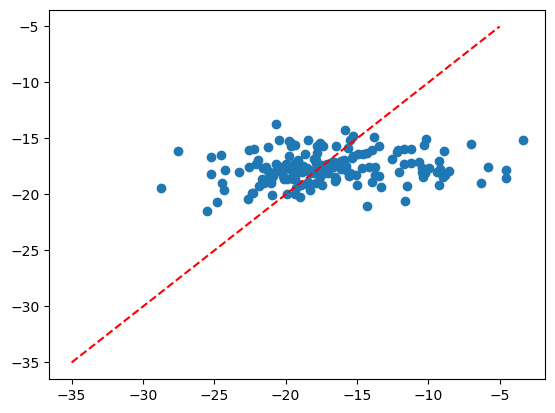

In [69]:
import matplotlib.pyplot as plt
plt.scatter(t_umo_obs.sel(time = transp_umo_prediction.time, method = "nearest").dv_dz_times_X.values, transp_umo_prediction.values)

plt.plot([-35, -5], [-35, -5], 'r--')

### DvDvz -> DvDz

In [545]:
dv_dz_merged_argo_2000.shape

(324, 242)

In [547]:
dv_dz_obs.shape

AttributeError: 'Dataset' object has no attribute 'shape'

In [578]:
dv_dz_target = dv_dz_obs.dv_dz_times_X
_dv_dz = dv_dz_target.isel(z=slice(-40, None))
dv_dz_fillup = xr.where(
    ~dv_dz_target.isnull(),
    dv_dz_target,
    (_dv_dz.isel(z=0) + _dv_dz.diff("z").ffill("z").cumsum("z")).interp(z=dv_dz_target.z)
)
dv_dz_target = dv_dz_fillup

dv_dz_target = dv_dz_target.sel(time = dv_dz_merged_argo_2000.time, method = 'nearest')

valid_ts_mask = dv_dz_target.isnull().sum('z') == 0

dv_dz_target = dv_dz_target.where(valid_ts_mask, drop = True)
dv_dz_merged_argo_2000 = dv_dz_merged_argo_2000.sel(time = dv_dz_target.time)

In [579]:
input_data = dv_dz_merged_argo_2000.where(dv_dz_merged_argo_2000.z > -2000, drop = True)

In [585]:
train_ratio = .75

indices = np.arange(input_data.time.shape[0])
np.random.shuffle(indices)

train_indices = indices[:int(train_ratio * indices.shape[0])]
test_indices = indices[int(train_ratio * indices.shape[0]):]


train_X = input_data.isel(time = train_indices).values
test_X = input_data.isel(time = test_indices).values


mean_dvdz_merged = np.mean(train_X, axis = 0)
std_dvdz_merged = np.std(train_X, axis = 0)

train_X_scaled = (train_X - mean_dvdz_merged) / std_dvdz_merged
test_X_scaled = (test_X - mean_dvdz_merged) / std_dvdz_merged

train_y = dv_dz_target.isel(time = train_indices).values
test_y = dv_dz_target.isel(time = test_indices).values

mean_per_z = np.mean(train_y, axis = 0)
std_per_z = np.std(train_y, axis = 0)

train_y_scaled = (train_y - mean_per_z) / std_per_z
test_y_scaled = (test_y - mean_per_z) / std_per_z



In [605]:
from sklearn.linear_model import Ridge, RidgeCV, MultiTaskLassoCV

# regressor = RidgeCV(alphas=[.01, .05,.08,.1, .15,.3, .5, 1, 5, 10, 15, 20, 25, 50, 100, 150,200,250,500,1000]).fit(train_X_scaled, train_y_scaled)
# regressor = MultiTaskLassoCV(alphas=[.01, .05,.08,.1, .15,.3, .5, 1, 5, 10, 15, 20, 25, 50, 100, 150,200,250,500,1000]).fit(train_X_scaled, train_y_scaled)
regressor = MultiTaskLassoCV(alphas=[.1]).fit(train_X_scaled, train_y_scaled)

In [606]:
regressor.score(test_X_scaled, test_y_scaled), regressor.alpha_

(-0.04909884286663061, 0.1)

In [607]:
test_predictions = regressor.predict(test_X_scaled)
test_predictions = (test_predictions * std_per_z) + mean_per_z

transport = prediction_to_tranport(test_predictions, dv_dz_target.time.isel(time = test_indices), dv_dz_target.z)

(
    transport.hvplot(label = 'LR')
    * t_umo_obs.sel(time = transport.time, method = 'nearest').hvplot(label = 'rapid')
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.LR    :Curve   [time]   (dv_dz_times_X)
   .Curve.Rapid :Curve   [time]   (dv_dz_times_X)